In [9]:
#IMPORTS
import csv
import collections
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
!pip install plotly
import plotly.express as px
from sklearn.decomposition import PCA
import pandas as pd
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import random
random.seed(10)
from matplotlib.pyplot import figure
import math
import matplotlib.patches as mpatches
from numpy import cov
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.patches as mpatches


In [14]:
#Inputs

#use_questions = 112
use_questions = 54
raw_data_path = '/Users/zoeweiss/Desktop/Desktop/lab(s)/barnighausen/TZAH2006/TZA.csv'
K = 5

#Assign categories to use in Gaussian mixture model
categories = {}
categories['general'] = list(range(0, 5))
categories['nutrition'] = list(range(5, 8))
categories['hygine'] = list(range(8, 12))
categories['violence'] = list(range(12, 19))
categories['mental_health'] = list(range(19, 27))
categories['tobacco'] = list(range(27, 33))
categories['alcohol'] = list(range(33, 38))
categories['drugs'] = list(range(38, 39))
categories['sexual_activity'] = list(range(39, 44))
categories['physical_activity'] = list(range(44, 49))
categories['protection'] = list(range(49, 54))
categories['other'] = list(range(54, 1+use_questions))


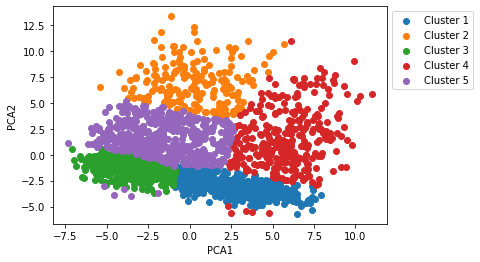

In [15]:
#RAW DATA


with open(raw_data_path, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

raw_data = []
for element in data[1:]:
    raw_data.append(element[:use_questions])

gmm_data = []
for person in raw_data:
    personal_data = []
    for entry in person:
        if entry.isnumeric()==True:
            personal_data.append(int(entry))
        else:
            personal_data.append(0)
    gmm_data.append(personal_data)
    
#Gaussian Mixture Model
pca = PCA(2)
pca.fit(gmm_data)
pca_data = pca.transform(gmm_data)
X=pca_data
# define the model
model = GaussianMixture(n_components=K)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label = 'Cluster '+str(1+cluster))
# show the plot
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


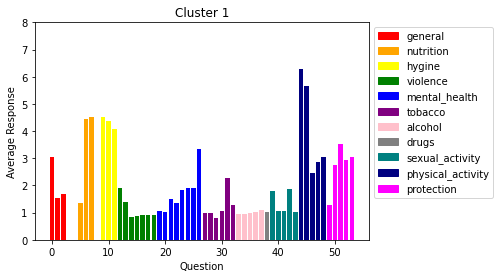

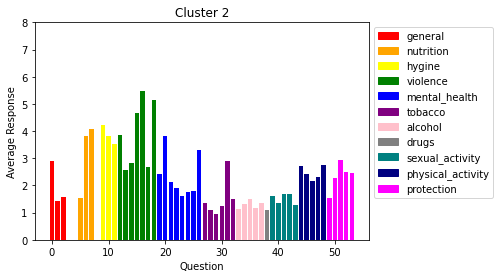

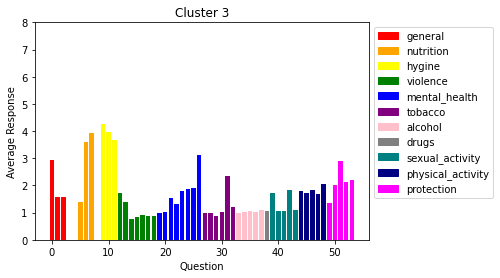

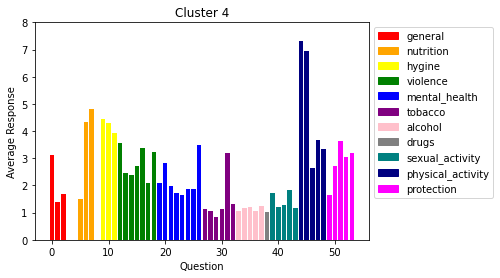

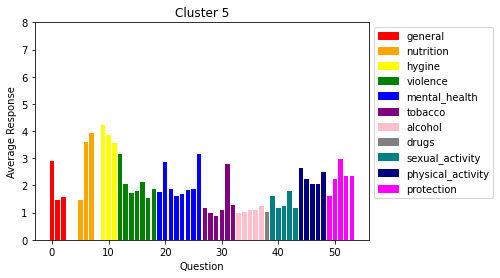

In [16]:

#Visualize the characteristics of the clusters
#Group people by cluster
all_cluster_data = []
for cluster in range(1+max(yhat)):
    data_by_cluster = []
    for person in range(len(yhat)):
        if yhat[person] == cluster:
            data_by_cluster.append(gmm_data[person])
    all_cluster_data.append(data_by_cluster)
#Find average score for each question in each cluster
for cluster in range(1+max(yhat)):
    question_averages = []
    for question in range(len(all_cluster_data[cluster][0])):
        question_values = []
        for person in range(len(all_cluster_data[cluster])):
            question_values.append(all_cluster_data[cluster][person][question])
        question_averages.append(np.mean(question_values))

    #Plot
    colors = ['red','orange','yellow','green','blue','purple','pink','grey','teal','navy', 'magenta', 'lime']
    use_cols = []
    patches = []
    handlelist = collections.OrderedDict()

    for question in range(len(question_averages)):
        found = 0
        for key in range(len(list(categories.values()))):
            if question in list(categories.values())[key]:
                found = 1
                use_cols.append(colors[list(categories.keys()).index(list(categories.keys())[key])])

                color = colors[list(categories.keys()).index(list(categories.keys())[key])]
                label = list(categories.keys())[key]
                if (color,label) not in handlelist:
                    handlelist[(color,label)] = mpatches.Patch(color=color, label=label)

        if found == 0:
            use_cols.append('white')
    plt.bar(range(len(question_averages)), question_averages, color = use_cols)
    plt.xlabel('Question')
    plt.ylabel('Average Response')
    plt.title('Cluster '+str(1+cluster))
    plt.legend(handles=list(handlelist.values()), numpoints=1, bbox_to_anchor = (1,1))
    plt.ylim(0, 8)
    plt.show()
    

In [17]:
#Make model to apply for future use

x, y = gmm_data, yhat 

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 10000).fit(x, y)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Mean Accuracy: 0.965 (0.011)


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       535
           1       0.98      0.98      0.98       192
           2       0.98      0.99      0.99       677
           3       0.98      0.96      0.97       301
           4       0.97      0.96      0.96       471

    accuracy                           0.98      2176
   macro avg       0.98      0.97      0.98      2176
weighted avg       0.98      0.98      0.98      2176



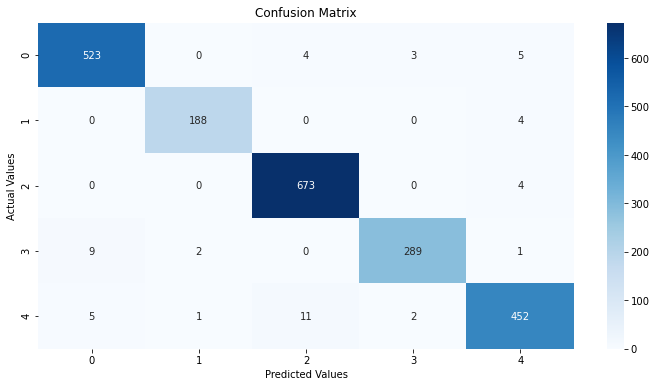

In [18]:
#Show error
y_pred = model.predict(x)
print(classification_report(y, y_pred))
cm=confusion_matrix(y,y_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')

In [ ]:
s